<a href="https://colab.research.google.com/github/mbruner3/Coursework-Portfolio/blob/main/MultistepLSTM_Predicting_Hospital_Cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing libraries needed for RNN Model.
import os
import datetime


# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Math operations
import numpy as np

# Random sampling
import random
import tensorflow as tf

# Keras API 
from tensorflow import keras

# Deep learning 
from keras.models import Input, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Concatenate, SimpleRNN, Masking, Flatten, GRU, Reshape, RepeatVector, TimeDistributed
from keras import losses
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from keras.regularizers import L1L2
import IPython
import IPython.display


SEED = 13
tf.random.set_seed(SEED)

In [ ]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]-1
    
    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag), 1:])
            
    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/main_out.csv')

df['SchedDate'] = pd.to_datetime(df.pop('SchedDate'), format='%Y.%m.%d %H:%M:%S')

In [ ]:
# Sorting by the date 
df.sort_values('SchedDate', inplace=True)

In [ ]:
#Looking at the format of the data.
df.head(15)

,Unnamed: 0,Other,General,Orthopedics,Urology,Gynecology,Other_ORIn_Out,General_ORIn_Out,Orthopedics_ORIn_Out,Urology_ORIn_Out,Gynecology_ORIn_Out,Other_SchedDur,General_SchedDur,Orthopedics_SchedDur,Urology_SchedDur,Gynecology_SchedDur,PatType_Admit Prior to Surgery,PatType_Ambulatory Surgery,PatType_Inpatient,PatType_NULL,PatType_To Come In,PatType_Discharge_Ambulatory Surgery,PatType_Discharge_Extended Recovery,PatType_Discharge_Inpatient,PatType_Discharge_Observation,PatType_Discharge_Outpatient in a Bed,PatType_Discharge_To Come In,CaseType_Elective,CaseType_Emergent,CaseType_Trauma,CaseType_Urgent,SurgeonAffiliation_CCF,SurgeonAffiliation_NULL,SurgeonAffiliation_PPG,SurgeonAffiliation_Private,Anestype_Block Regional - Extremity Lower,Anestype_Block Regional - Extremity Upper,Anestype_Block Regional - Other,Anestype_Epidural,Anestype_General,Anestype_Local,Anestype_Monitored Anesthesia Care,Anestype_None,Anestype_NULL,Anestype_Procedural Sedation,Anestype_Spinal,Anestype_Spinal-Epidural Combo,Scheduled_Ahead_days_bin_00-Day of,Scheduled_Ahead_days_bin_01-1 to 2,Scheduled_Ahead_days_bin_02-3 to 5,Scheduled_Ahead_days_bin_03-6 to 9,Scheduled_Ahead_days_bin_04-10 to 12,Scheduled_Ahead_days_bin_05-12 to 15,Scheduled_Ahead_days_bin_06-16 to 20,Scheduled_Ahead_days_bin_07-21 to 25,Scheduled_Ahead_days_bin_08-26 to 30,Scheduled_Ahead_days_bin_09-31 to 45,Scheduled_Ahead_days_bin_10-46 to 60,Scheduled_Ahead_days_bin_11-61 to 90,Scheduled_Ahead_days_bin_12-90 or more,SchedDate_Day_Friday,SchedDate_Day_Monday,SchedDate_Day_Saturday,SchedDate_Day_Sunday,SchedDate_Day_Thursday,SchedDate_Day_Tuesday,SchedDate_Day_Wednesday,SchedDate_Month_1,SchedDate_Month_2,SchedDate_Month_3,SchedDate_Month_4,SchedDate_Month_5,SchedDate_Month_6,SchedDate_Month_7,SchedDate_Month_8,SchedDate_Month_9,SchedDate_Month_10,SchedDate_Month_11,SchedDate_Month_12,SchedDate
0,1,1,4,9,10,2,182,459,1492,1012,119,150,755,2010,1602,255,0,16,0,0,10,15,3,8,0,0,0,24,0,0,2,8,0,15,3,0,0,0,0,20,0,2,0,0,0,4,0,1,1,5,0,5,3,2,2,7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-02
1,2,5,2,8,10,5,879,440,989,498,499,1170,660,1590,1270,810,0,23,0,0,7,17,5,7,1,0,0,30,0,0,0,8,0,15,7,0,0,0,0,27,0,2,0,0,0,1,0,0,0,3,8,4,3,5,2,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-03
2,3,4,7,2,3,2,602,1187,238,150,161,720,1630,360,280,260,0,15,0,0,3,11,3,3,1,0,0,18,0,0,0,0,0,11,7,0,0,0,0,17,0,1,0,0,0,0,0,0,2,0,1,3,2,2,1,7,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-04
3,4,4,7,3,12,4,795,1400,401,947,364,1050,1425,570,1640,565,0,23,0,0,7,18,4,8,0,0,0,29,1,0,0,12,0,12,6,0,0,0,0,25,1,2,0,0,0,2,0,0,0,3,9,4,1,1,2,10,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-05
4,5,5,8,1,10,1,451,1004,94,604,22,840,1475,120,1322,120,0,23,0,0,2,19,3,1,1,1,0,25,0,0,0,10,0,12,3,0,0,0,0,21,1,3,0,0,0,0,0,0,0,2,3,6,3,4,4,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-06
5,6,0,0,0,0,1,0,0,0,0,46,0,0,0,0,120,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-07
6,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-08
7,8,6,5,14,1,4,882,570,1855,80,678,1135,750,2405,135,680,1,23,0,0,6,14,5,10,1,0,0,29,0,0,1,1,0,27,2,0,0,0,0,26,0,2,0,0,0,2,0,0,0,6,0,8,2,3,4,1,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-09
8,9,10,4,6,9,7,1800,526,685,661,950,1770,700,930,930,1180,0,25,0,0,11,20,5,10,1,0,0,33,0,1,2,9,0,23,4,0,0,0,0,33,0,3,0,0,0,0,0,1,1,4,5,1,10,3,4,1,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-10
9,10,3,12,6,4,3,560,1834,885,341,309,480,2510,1050,510,440,0,21,0,0,7,18,2,8,0,0,0,28,0,0,0,4,0,20,4,0,0,0,0,25,0,1,0,0,0,2,0,0,4,1,8,1,1,6,1,1,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2017-10-11


In [ ]:
# Listing the min and the max dates 
print(f"First date {min(df['SchedDate'])}")
print(f"Most recent date {max(df['SchedDate'])}")

First date 2017-10-02 00:00:00
Most recent date 2021-02-05 00:00:00


In [ ]:
print(f"Total unique dates in the dataset: {len(set(df['SchedDate']))}")

Total unique dates in the dataset: 1223


In [ ]:
print(f"Number of rows in the dataset: {df.shape[0]}")

Number of rows in the dataset: 1223


In [ ]:
#with pd.option_context('display.max_columns', 100):
    #print(df.describe())
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Scheduled_Ahead_days_bin_11-61 to 90'], axis = 1)

In [ ]:
# Subseting only the needed columns 
df['SchedDate'] = [datetime.datetime.timestamp(x) for x in df['SchedDate']]

nrows = df.shape[0]
nrows

1223

In [ ]:
target_index = 'Orthopedics'
path = r'C:\Users\markd\Documents\main_out_ortho_predict.xlsx'
cols = list(df.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index(target_index)) #Remove target_index from list
df = df[[target_index]+ cols] #Create new dataframe with target_index at the beginning of dataset
df.head(5)

,Orthopedics,Other,General,Urology,Gynecology,Other_ORIn_Out,General_ORIn_Out,Orthopedics_ORIn_Out,Urology_ORIn_Out,Gynecology_ORIn_Out,Other_SchedDur,General_SchedDur,Orthopedics_SchedDur,Urology_SchedDur,Gynecology_SchedDur,PatType_Admit Prior to Surgery,PatType_Ambulatory Surgery,PatType_Inpatient,PatType_NULL,PatType_To Come In,PatType_Discharge_Ambulatory Surgery,PatType_Discharge_Extended Recovery,PatType_Discharge_Inpatient,PatType_Discharge_Observation,PatType_Discharge_Outpatient in a Bed,PatType_Discharge_To Come In,CaseType_Elective,CaseType_Emergent,CaseType_Trauma,CaseType_Urgent,SurgeonAffiliation_CCF,SurgeonAffiliation_NULL,SurgeonAffiliation_PPG,SurgeonAffiliation_Private,Anestype_Block Regional - Extremity Lower,Anestype_Block Regional - Extremity Upper,Anestype_Block Regional - Other,Anestype_Epidural,Anestype_General,Anestype_Local,Anestype_Monitored Anesthesia Care,Anestype_None,Anestype_NULL,Anestype_Procedural Sedation,Anestype_Spinal,Anestype_Spinal-Epidural Combo,Scheduled_Ahead_days_bin_00-Day of,Scheduled_Ahead_days_bin_01-1 to 2,Scheduled_Ahead_days_bin_02-3 to 5,Scheduled_Ahead_days_bin_03-6 to 9,Scheduled_Ahead_days_bin_04-10 to 12,Scheduled_Ahead_days_bin_05-12 to 15,Scheduled_Ahead_days_bin_06-16 to 20,Scheduled_Ahead_days_bin_07-21 to 25,Scheduled_Ahead_days_bin_08-26 to 30,Scheduled_Ahead_days_bin_09-31 to 45,Scheduled_Ahead_days_bin_10-46 to 60,Scheduled_Ahead_days_bin_12-90 or more,SchedDate_Day_Friday,SchedDate_Day_Monday,SchedDate_Day_Saturday,SchedDate_Day_Sunday,SchedDate_Day_Thursday,SchedDate_Day_Tuesday,SchedDate_Day_Wednesday,SchedDate_Month_1,SchedDate_Month_2,SchedDate_Month_3,SchedDate_Month_4,SchedDate_Month_5,SchedDate_Month_6,SchedDate_Month_7,SchedDate_Month_8,SchedDate_Month_9,SchedDate_Month_10,SchedDate_Month_11,SchedDate_Month_12,SchedDate
0,9,1,4,10,2,182,459,1492,1012,119,150,755,2010,1602,255,0,16,0,0,10,15,3,8,0,0,0,24,0,0,2,8,0,15,3,0,0,0,0,20,0,2,0,0,0,4,0,1,1,5,0,5,3,2,2,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.506902e+09
1,8,5,2,10,5,879,440,989,498,499,1170,660,1590,1270,810,0,23,0,0,7,17,5,7,1,0,0,30,0,0,0,8,0,15,7,0,0,0,0,27,0,2,0,0,0,1,0,0,0,3,8,4,3,5,2,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1.506989e+09
2,2,4,7,3,2,602,1187,238,150,161,720,1630,360,280,260,0,15,0,0,3,11,3,3,1,0,0,18,0,0,0,0,0,11,7,0,0,0,0,17,0,1,0,0,0,0,0,0,2,0,1,3,2,2,1,7,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1.507075e+09
3,3,4,7,12,4,795,1400,401,947,364,1050,1425,570,1640,565,0,23,0,0,7,18,4,8,0,0,0,29,1,0,0,12,0,12,6,0,0,0,0,25,1,2,0,0,0,2,0,0,0,3,9,4,1,1,2,10,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.507162e+09
4,1,5,8,10,1,451,1004,94,604,22,840,1475,120,1322,120,0,23,0,0,2,19,3,1,1,1,0,25,0,0,0,10,0,12,3,0,0,0,0,21,1,3,0,0,0,0,0,0,0,2,3,6,3,4,4,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1.507248e+09


In [ ]:
# Spliting into train and test sets
train = df[0:int(nrows * (.7))]
val = df[int(nrows * (.7)):int(nrows * (.9))]
test = df[int(nrows * (.9)):]

In [ ]:
train_mean = train.mean()
train_std = train.std()
train_df = (train - train_mean) / train_std
val_df = (val - train_mean) / train_std
test_df = (test - train_mean) / train_std
ts = pd.concat([train_df, val_df, test_df])

In [ ]:
lag = 30

# Steps ahead to forecast 
n_ahead = 14

# Share of obs in testing 
test_share = 0.1

# Epochs for training
epochs = 2000

# Batch size 
batch_size = 30

In [ ]:
# Subseting only the needed columns 
ts = df

nrows = ts.shape[0]

# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_share))]
test = ts[int(nrows * (1 - test_share)):]

# Scaling the data 
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame 
ts_s = pd.concat([train, test])

In [ ]:
X, Y = create_X_Y(ts_s.values, lag=lag, n_ahead=n_ahead, target_index=0)

n_ft = X.shape[2]

In [ ]:
# Spliting into train and test sets 
Xtrain, Ytrain = X[0:int(X.shape[0] * (1 - test_share))], Y[0:int(X.shape[0] * (1 - test_share))]
Xval, Yval = X[int(X.shape[0] * (1 - test_share)):], Y[int(X.shape[0] * (1 - test_share)):]

In [ ]:
print(f"Shape of training data: {Xtrain.shape}")
print(f"Shape of the target data: {Ytrain.shape}")

print(f"Shape of validation data: {Xval.shape}")
print(f"Shape of the validation target data: {Yval.shape}")

Shape of training data: (1061, 30, 77)
Shape of the target data: (1061, 14)
Shape of validation data: (118, 30, 77)
Shape of the validation target data: (118, 14)


In [ ]:
class NNMultistepModel():
    
    def __init__(self, X, Y, n_outputs, n_lag, n_ft, batch, epochs, Xval=None, Yval=None, patience=2):
        
        # Series signal 
        #Model for Ortho & General
        lstm = Sequential()
        lstm.add(LSTM(8, return_sequences=True, input_shape=(n_lag,n_ft)))
        lstm.add(LSTM(16, return_sequences=False))
        lstm.add(Dense(n_outputs))
        
        #Model for Urology
        #lstm = Sequential()
        #lstm.add(GRU(4, return_sequences=False, input_shape=(n_lag,n_ft)))
        #lstm.add(Dense(n_outputs))
        
        self.model = lstm
        self.batch = batch 
        self.epochs = epochs
        self.Xval = Xval
        self.Yval = Yval
        self.X = X
        self.Y = Y
        self.patience = patience

    def trainCallback(self):
        return EarlyStopping(monitor='loss', patience=self.patience)

    def train(self):
        # Getting the untrained model 
        empty_model = self.model
        
        # Initiating the optimizer
        optimizer = keras.optimizers.Adam(learning_rate = .005)  

        # Compiling the model
        empty_model.compile(loss=losses.MeanAbsoluteError(), optimizer=optimizer)

        if (self.Xval is not None) & (self.Yval is not None):
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch, 
                validation_data=(self.Xval, self.Yval), 
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        else:
            history = empty_model.fit(
                self.X, 
                self.Y, 
                epochs=self.epochs, 
                batch_size=self.batch,
                shuffle=False,
                callbacks=[self.trainCallback()]
            )
        
        # Saving to original model attribute in the class
        self.model = empty_model
        
        # Returning the training history
        return history
    
    def predict(self, X):
        return self.model.predict(X)

In [ ]:
lstm = NNMultistepModel(X=Xtrain, Y=Ytrain, n_outputs=n_ahead, n_lag=lag, n_ft=n_ft, batch=batch_size, epochs=10, 
                        Xval=Xval, Yval=Yval)

In [ ]:
lstm.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 8)             2752      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense (Dense)                (None, 14)                238       
Total params: 4,590
Trainable params: 4,590
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = lstm.train()

Epoch 1/10
36/36 [==============================] - 5s 45ms/step - loss: 0.8786 - val_loss: 0.5949
Epoch 2/10
36/36 [==============================] - 1s 22ms/step - loss: 0.7621 - val_loss: 0.4574
Epoch 3/10
36/36 [==============================] - 1s 21ms/step - loss: 0.6411 - val_loss: 0.4203
Epoch 4/10
36/36 [==============================] - 1s 22ms/step - loss: 0.5997 - val_loss: 0.4222
Epoch 5/10
36/36 [==============================] - 1s 22ms/step - loss: 0.5566 - val_loss: 0.4082
Epoch 6/10
36/36 [==============================] - 1s 23ms/step - loss: 0.5226 - val_loss: 0.4270
Epoch 7/10
36/36 [==============================] - 1s 22ms/step - loss: 0.4962 - val_loss: 0.4566
Epoch 8/10
36/36 [==============================] - 1s 22ms/step - loss: 0.4876 - val_loss: 0.4048
Epoch 9/10
36/36 [==============================] - 1s 22ms/step - loss: 0.4631 - val_loss: 0.4040
Epoch 10/10
36/36 [==============================] - 1s 22ms/step - loss: 0.4472 - val_loss: 0.4244


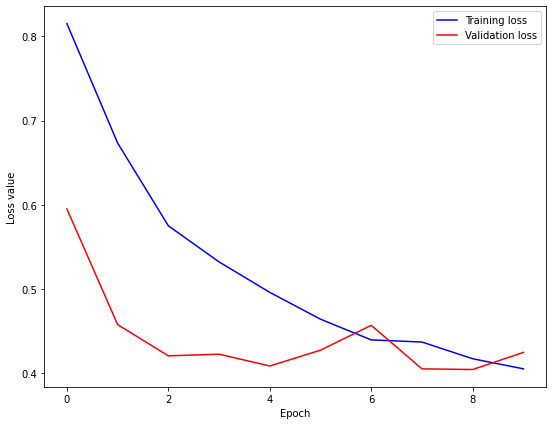

In [ ]:
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

n_epochs = range(len(loss))

plt.figure(figsize=(9, 7))
plt.plot(n_epochs, loss, 'r', label='Training loss', color='blue')
if val_loss is not None:
    plt.plot(n_epochs, val_loss, 'r', label='Validation loss', color='red')
plt.legend(loc=0)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

In [ ]:
#with pd.option_context('display.max_columns', 100):
    #print(train_df.describe())
loss

[0.8152674436569214,
 0.6732354760169983,
 0.5748603940010071,
 0.5319390892982483,
 0.4957289695739746,
 0.4638337194919586,
 0.4392380118370056,
 0.43669694662094116,
 0.4168102443218231,
 0.4048408567905426]

In [ ]:
val_loss

[0.5949217677116394,
 0.45742759108543396,
 0.42029061913490295,
 0.4222465753555298,
 0.4082053601741791,
 0.42704999446868896,
 0.4565672278404236,
 0.40479859709739685,
 0.4040406048297882,
 0.42441537976264954]

In [ ]:
yhat = [x[0] for x in lstm.predict(Xval)]
y = [y[0] for y in Yval]

In [ ]:
df['SchedDate'] = [datetime.datetime.fromtimestamp(x) for x in df['SchedDate']]
df['SchedDate']

0      2017-10-02
1      2017-10-03
2      2017-10-04
3      2017-10-05
4      2017-10-06
          ...    
1218   2021-02-01
1219   2021-02-02
1220   2021-02-03
1221   2021-02-04
1222   2021-02-05
Name: SchedDate, Length: 1223, dtype: datetime64[ns]

In [ ]:
Xval.shape

(118, 30, 77)

In [ ]:
train_std.head

<bound method NDFrame.head of Orthopedics           4.246164e+00
Other                 3.875940e+00
General               4.562596e+00
Urology               5.812848e+00
Gynecology            2.985946e+00
                          ...     
SchedDate_Month_9     2.742122e-01
SchedDate_Month_10    2.836881e-01
SchedDate_Month_11    2.742122e-01
SchedDate_Month_12    2.783306e-01
SchedDate             2.744815e+07
Length: 78, dtype: float64>

In [ ]:
train_std[target_index]

4.246163937130898

In [ ]:
ts_s.tail(10)

,Orthopedics,Other,General,Urology,Gynecology,Other_ORIn_Out,General_ORIn_Out,Orthopedics_ORIn_Out,Urology_ORIn_Out,Gynecology_ORIn_Out,Other_SchedDur,General_SchedDur,Orthopedics_SchedDur,Urology_SchedDur,Gynecology_SchedDur,PatType_Admit Prior to Surgery,PatType_Ambulatory Surgery,PatType_Inpatient,PatType_NULL,PatType_To Come In,PatType_Discharge_Ambulatory Surgery,PatType_Discharge_Extended Recovery,PatType_Discharge_Inpatient,PatType_Discharge_Observation,PatType_Discharge_Outpatient in a Bed,PatType_Discharge_To Come In,CaseType_Elective,CaseType_Emergent,CaseType_Trauma,CaseType_Urgent,SurgeonAffiliation_CCF,SurgeonAffiliation_NULL,SurgeonAffiliation_PPG,SurgeonAffiliation_Private,Anestype_Block Regional - Extremity Lower,Anestype_Block Regional - Extremity Upper,Anestype_Block Regional - Other,Anestype_Epidural,Anestype_General,Anestype_Local,Anestype_Monitored Anesthesia Care,Anestype_None,Anestype_NULL,Anestype_Procedural Sedation,Anestype_Spinal,Anestype_Spinal-Epidural Combo,Scheduled_Ahead_days_bin_00-Day of,Scheduled_Ahead_days_bin_01-1 to 2,Scheduled_Ahead_days_bin_02-3 to 5,Scheduled_Ahead_days_bin_03-6 to 9,Scheduled_Ahead_days_bin_04-10 to 12,Scheduled_Ahead_days_bin_05-12 to 15,Scheduled_Ahead_days_bin_06-16 to 20,Scheduled_Ahead_days_bin_07-21 to 25,Scheduled_Ahead_days_bin_08-26 to 30,Scheduled_Ahead_days_bin_09-31 to 45,Scheduled_Ahead_days_bin_10-46 to 60,Scheduled_Ahead_days_bin_12-90 or more,SchedDate_Day_Friday,SchedDate_Day_Monday,SchedDate_Day_Saturday,SchedDate_Day_Sunday,SchedDate_Day_Thursday,SchedDate_Day_Tuesday,SchedDate_Day_Wednesday,SchedDate_Month_1,SchedDate_Month_2,SchedDate_Month_3,SchedDate_Month_4,SchedDate_Month_5,SchedDate_Month_6,SchedDate_Month_7,SchedDate_Month_8,SchedDate_Month_9,SchedDate_Month_10,SchedDate_Month_11,SchedDate_Month_12,SchedDate
1213,0.586198,0.858443,1.052630,-0.253826,-0.365957,0.550456,1.052157,0.318862,0.392462,0.685060,1.035050,0.982369,0.548927,-0.064177,0.657368,-0.195007,0.552996,-0.121436,-0.04266,0.077826,0.350387,0.737868,0.522167,-0.510431,-0.067543,-0.067543,0.494395,-0.171316,-0.141301,-0.525605,0.383508,-0.030151,0.728905,-0.827830,-0.121436,-0.170536,-0.030151,-0.030151,0.494283,-0.280823,-0.136504,-0.090784,-0.10931,-0.04266,1.037019,-0.030151,3.998767,-0.136087,-0.873046,-0.668377,0.218713,-0.045937,1.912218,0.584174,-0.912094,0.122835,1.137004,2.185987,-0.407846,-0.409360,-0.407846,-0.407846,-0.407846,-0.407846,2.449675,3.289090,-0.289254,-0.303759,-0.298375,-0.303759,-0.298375,-0.303759,-0.303759,-0.298375,-0.310841,-0.298375,-0.303759,2.088534
1214,-0.591336,1.116445,0.395110,0.778370,1.643457,0.579095,0.138463,-0.596629,1.233774,0.542305,0.664030,0.373719,-0.674557,1.123930,1.494136,-0.195007,0.979123,-0.121436,-0.04266,-0.164692,0.605186,3.208123,-0.671482,-0.510431,-0.067543,-0.067543,0.787693,-0.171316,-0.141301,-0.525605,0.887320,-0.030151,0.728905,-0.109398,-0.121436,-0.170536,-0.030151,-0.030151,0.964099,-0.280823,-0.505433,-0.090784,-0.10931,-0.04266,0.187636,-0.030151,-0.435350,-0.136087,-0.873046,1.768413,0.218713,3.438907,0.273068,-0.936752,-0.912094,0.122835,1.137004,-0.627491,-0.407846,-0.409360,-0.407846,-0.407846,2.449675,-0.407846,-0.407846,3.289090,-0.289254,-0.303759,-0.298375,-0.303759,-0.298375,-0.303759,-0.303759,-0.298375,-0.310841,-0.298375,-0.303759,2.091682
1215,-0.120323,0.084437,1.271804,1.122435,-1.035761,0.361780,1.037420,0.037320,1.904912,-0.964562,0.316199,0.903834,-0.146089,1.841745,-1.016169,-0.195007,0.695038,-0.121436,-0.04266,-0.164692,0.690120,0.384975,0.044708,-0.510431,-0.067543,-0.067543,0.494395,-0.171316,-0.141301,1.116911,1.391133,-0.030151,0.187151,-0.468614,-0.121436,-0.170536,-0.030151,-0.030151,0.829866,-0.280823,-0.874363,-0.090784,-0.10931,-0.04266,-0.661746,-0.030151,-0.435350,-0.734872,-0.873046,0.027849,0.723083,0.389669,0.682855,2.865562,-0.456254,0.706502,0.142012,-0.627491,2.449675,-0.409360,-0.407846,-0.407846,-0.407846,-0.407846,-0.407846,3.289090,-0.289254,-0.303759,-0.298375,-0.303759

In [ ]:
# Creating the frame to store both predictions
# create an array of 7 dates starting at '2015-02-24', one per day
a_date = datetime.date(2021, 2, 6)
days = datetime.timedelta(Xval.shape[0]-n_ahead)
new_date = a_date - days
days = pd.date_range(new_date, periods=Xval.shape[0]-n_ahead, freq='D')
len(days)

104

In [ ]:
yhat = [x[0] for x in lstm.predict(Xval)]
y = [y[0] for y in Yval]
len(yhat)

118

In [ ]:
original_normed = ts_s[['SchedDate', target_index]].tail(len(days))

In [ ]:
original_normed['SchedDate'] = days

In [ ]:
zeros_date = [pd.DataFrame(pd.date_range('2021-02-06', periods=n_ahead), columns = ['SchedDate'])]
zeros_date

[    SchedDate
 0  2021-02-06
 1  2021-02-07
 2  2021-02-08
 3  2021-02-09
 4  2021-02-10
 5  2021-02-11
 6  2021-02-12
 7  2021-02-13
 8  2021-02-14
 9  2021-02-15
 10 2021-02-16
 11 2021-02-17
 12 2021-02-18
 13 2021-02-19]

In [ ]:
original_normed = original_normed.append(zeros_date)
len(original_normed)

118

In [ ]:
len(days)

104

In [ ]:
frame = pd.concat([
    pd.DataFrame({'Day': original_normed['SchedDate'], 'Normed': yhat, 'type': 'Forecast'}),
    pd.DataFrame({'Day': original_normed['SchedDate'], 'Normed': original_normed[target_index], 'type': 'Original'})
])

# Creating the unscaled values column
frame['Case_Num'] = [(x * train_std[target_index]) + train_mean[target_index] for x in frame['Normed']]

# Pivoting
pivoted = frame.pivot_table(index='Day', columns=['type'])
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['Diff'] = pivoted['Case_Num_Original'] - pivoted['Case_Num_Forecast']
pivoted['Diff_Abs'] = [abs(x) for x in pivoted['Diff']]

In [ ]:
df[df['SchedDate']=='2021-02-05']

,Orthopedics,Other,General,Urology,Gynecology,Other_ORIn_Out,General_ORIn_Out,Orthopedics_ORIn_Out,Urology_ORIn_Out,Gynecology_ORIn_Out,Other_SchedDur,General_SchedDur,Orthopedics_SchedDur,Urology_SchedDur,Gynecology_SchedDur,PatType_Admit Prior to Surgery,PatType_Ambulatory Surgery,PatType_Inpatient,PatType_NULL,PatType_To Come In,PatType_Discharge_Ambulatory Surgery,PatType_Discharge_Extended Recovery,PatType_Discharge_Inpatient,PatType_Discharge_Observation,PatType_Discharge_Outpatient in a Bed,PatType_Discharge_To Come In,CaseType_Elective,CaseType_Emergent,CaseType_Trauma,CaseType_Urgent,SurgeonAffiliation_CCF,SurgeonAffiliation_NULL,SurgeonAffiliation_PPG,SurgeonAffiliation_Private,Anestype_Block Regional - Extremity Lower,Anestype_Block Regional - Extremity Upper,Anestype_Block Regional - Other,Anestype_Epidural,Anestype_General,Anestype_Local,Anestype_Monitored Anesthesia Care,Anestype_None,Anestype_NULL,Anestype_Procedural Sedation,Anestype_Spinal,Anestype_Spinal-Epidural Combo,Scheduled_Ahead_days_bin_00-Day of,Scheduled_Ahead_days_bin_01-1 to 2,Scheduled_Ahead_days_bin_02-3 to 5,Scheduled_Ahead_days_bin_03-6 to 9,Scheduled_Ahead_days_bin_04-10 to 12,Scheduled_Ahead_days_bin_05-12 to 15,Scheduled_Ahead_days_bin_06-16 to 20,Scheduled_Ahead_days_bin_07-21 to 25,Scheduled_Ahead_days_bin_08-26 to 30,Scheduled_Ahead_days_bin_09-31 to 45,Scheduled_Ahead_days_bin_10-46 to 60,Scheduled_Ahead_days_bin_12-90 or more,SchedDate_Day_Friday,SchedDate_Day_Monday,SchedDate_Day_Saturday,SchedDate_Day_Sunday,SchedDate_Day_Thursday,SchedDate_Day_Tuesday,SchedDate_Day_Wednesday,SchedDate_Month_1,SchedDate_Month_2,SchedDate_Month_3,SchedDate_Month_4,SchedDate_Month_5,SchedDate_Month_6,SchedDate_Month_7,SchedDate_Month_8,SchedDate_Month_9,SchedDate_Month_10,SchedDate_Month_11,SchedDate_Month_12,SchedDate
1222,6,10,11,10,2,1294,980,465,1447,98,1350,1380,780,1725,150,0,37,0,0,2,32,4,2,1,0,0,39,0,0,0,9,0,29,1,0,0,0,0,34,0,5,0,0,0,0,0,1,1,3,7,2,3,7,5,2,8,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2021-02-05


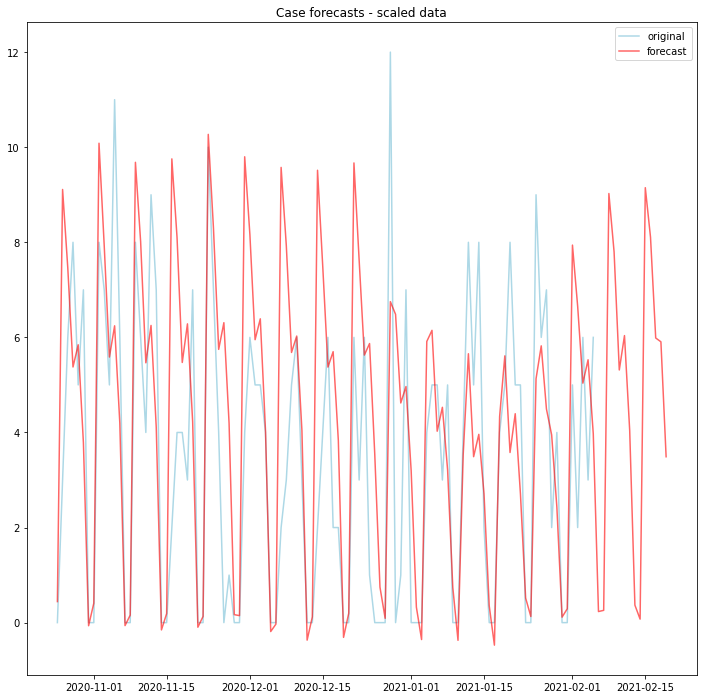

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(pivoted.index, pivoted.Case_Num_Original, color='lightblue', label='original')
plt.plot(pivoted.index, pivoted.Case_Num_Forecast, color='red', label='forecast', alpha=0.6)
plt.title('Case forecasts - scaled data')
plt.legend()
plt.show()

In [ ]:
pivoted.tail(20)

,Case_Num_Forecast,Case_Num_Original,Normed_Forecast,Normed_Original,Diff,Diff_Abs
Day,,,,,,
2021-01-31,0.291808,0.0,-0.993627,-1.062349,-0.291808,0.291808
2021-02-01,7.941192,5.0,0.807855,0.115184,-2.941192,2.941192
2021-02-02,6.653060,2.0,0.504491,-0.591336,-4.653060,4.653060
2021-02-03,5.037475,6.0,0.124010,0.350691,0.962525,0.962525
2021-02-04,5.528492,3.0,0.239648,-0.355829,-2.528492,2.528492
2021-02-05,3.971019,6.0,-0.127148,0.350691,2.028981,2.028981
2021-02-06,0.233057,NaN,-1.007463,NaN,NaN,NaN
2021-02-07,0.258416,NaN,-1.001491,NaN,NaN,NaN
2021-02-08,9.025928,NaN,1.063317,NaN,NaN,NaN


In [ ]:
print(f"Average absolute mean error: {round(pivoted['Diff_Abs'].sum() / pivoted.shape[0], 2)} cases")

Average absolute mean error: 1.72 cases


In [ ]:
pivoted.to_excel(path, index = True, header = True)